In [8]:
import alpdesign as alp
from alpdesign.seq import *
from alpdesign.mlp import *
from alpdesign.utils import *
import jax 
from jax_unirep import get_reps
import haiku as hk

In [9]:
def hamming(seq1, seq2): # seq1 and seq2 are of same length
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    hamming_distance = 0.
    for i in range(len(seqlist1)):
        if seqlist1[i] == seqlist2[i]:
            continue
        hamming_distance += 1.
    return hamming_distance / len(seqlist1)

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

In [12]:
print(jnp.shape(oh_vec))

(26, 20)


In [11]:
key = jax.random.PRNGKey(0)
batch_size=16
target_seq = 'GIGAVLKVLTTGLPALISWIKRKRQQ'
oh_vec = encode_seq(list(target_seq))
oh_unirep = seq2useq(oh_vec)
target_rep = differentiable_jax_unirep(oh_unirep)
#print(target_rep.shape)
seqs = ['GIGAVLKVLKAGLPALIVTLKRKIVQ',
       'PPGATLKKHTTGSVALISWIWARIQQ',
       'GIGAVLKVLTTGLKTLISAAKRKRAA',
       'HAPPVLKVLTTGLAPPLVWIKRKRTH',
       'GIGAVLUIHKLSSVAAWRPPKRKRQQ',
       'PTWIIFLKAQWEQHSNLTNMRTFPEV',
        'TISHFVCNHDICAWIKDMQAMQIKMC',
        'CESWLWKRLFDGHADRWRSMPDYPIW',
        'YLVENPLMFPLVAAFIHQWTRQISWH',
        'QTEERLEAQISIYYIGAWSHYKVTDE']

val_seqs = ['PTWIIFLKAQAVLKVLLTNMRTFPEV',
'TISHFVCNHDICAWIKDMQAMQIKMC',
'CESWLWKRCESWLWKRWRSMPDYPIW',
'YYIGNPLMFPLVAAFIHQWTRQISWH',
'QTEERLEAQISIYYIGAWSHYHAPPV']

#plt.rcParams["figure.figsize"] = (12,12)
#fig, axs = plt.subplots(3)
forward = hk.without_apply_rng(hk.transform(alp.model_forward))

#@jax.jit
def single_loop(key, seqs, val_seqs, params):
    print('loop start')

    # get labels
    labels = []
    for seq in seqs:
        labels.append(hamming(target_seq, seq))
    labels = jnp.array(labels)
    
    val_labels = []
    for val_seq in val_seqs:
        val_labels.append(hamming(target_seq, val_seq))
    val_labels = jnp.array(val_labels)
    
    reps = get_reps(seqs)[0]
    val_reps = get_reps(val_seqs)[0]
    key, _ = jax.random.split(key, num=2)
    print('Training MLP...')
    params, mlp_loss, mlp_val_loss= alp.ensemble_train(key, forward, reps, labels, val_seqs=val_reps, val_labels=val_labels, params=params, batch_size=4, epochs=100, learning_rate=1e-3)
    #axs[i].plot(mlp_loss)
    print('Optimizing...')
    final_vec = alp.bayes_opt(forward, params, labels)
    
    # need to adjust length in the future
    logits = jax.random.normal(key, shape=(jnp.shape(oh_vec)))
    b_logits = jax.random.normal(key, shape=(batch_size,*jnp.shape(oh_vec)))
    seq_params = forward_seqprop.init(key, logits)
    #loss_traces, loss, _seqs = pso_train(key, final_vec, b_logits, params, alp.seq.train_seqprop, batch_size, bag_num)
    print('Finding sequence...')
    loss_traces, loss, _seqs = pso_train(key, final_vec, b_logits, seq_params)
    gen_seqs = []
    for seq in _seqs:
        seq = alp.utils.decode_seq(seq)
        str = ""
        gen_seqs.append(str.join(seq))
    # add data points
    seqs = [*seqs, *gen_seqs]
    return seqs, mlp_loss, mlp_val_loss, loss_traces, params

    
# for i in range(3):
#     losses = []
#     key, _ = jax.random.split(key, num=2)
#     seqs, mlp_loss = single_loop(key, seqs)
#     print(seqs)
#     losses.append(mlp_loss)
#     #axs[i].plot(mlp_loss)

In [7]:
loop_mlp_loss = []
loop_mlp_val_loss = []
loop_seq_loss = []
loop_seq = []
params = None
for i in range(3):
    key, _ = jax.random.split(key, num=2)
    seqs, mlp_loss, mlp_val_loss, loss_traces, params= single_loop(key, seqs, val_seqs, params)
    loop_mlp_loss.append(mlp_loss)
    loop_mlp_val_loss.append(mlp_val_loss)
    loop_seq_loss.append(loss_traces)
    loop_seq.append(seqs)

loop start
Training MLP...
Optimizing...
Finding sequence...
loop start
Training MLP...
Optimizing...
Finding sequence...
loop start
Training MLP...
Optimizing...
Finding sequence...


In [8]:
print(loop_mlp_val_loss)

[[DeviceArray(-3.3517303, dtype=float32), DeviceArray(-5.5987496, dtype=float32), DeviceArray(-5.456944, dtype=float32), DeviceArray(-4.3570876, dtype=float32), DeviceArray(-4.9513965, dtype=float32), DeviceArray(-5.896898, dtype=float32), DeviceArray(-6.044953, dtype=float32), DeviceArray(-5.495544, dtype=float32), DeviceArray(-5.947698, dtype=float32), DeviceArray(-6.325908, dtype=float32), DeviceArray(-6.2976503, dtype=float32), DeviceArray(-6.3405757, dtype=float32), DeviceArray(-6.9402757, dtype=float32), DeviceArray(-7.1784744, dtype=float32), DeviceArray(-7.6821303, dtype=float32), DeviceArray(-7.8863883, dtype=float32), DeviceArray(-8.986307, dtype=float32), DeviceArray(-9.710115, dtype=float32), DeviceArray(-10.567292, dtype=float32), DeviceArray(-11.208298, dtype=float32), DeviceArray(-12.821317, dtype=float32), DeviceArray(-13.619285, dtype=float32), DeviceArray(-15.943698, dtype=float32), DeviceArray(-14.736488, dtype=float32), DeviceArray(-18.693075, dtype=float32), Device

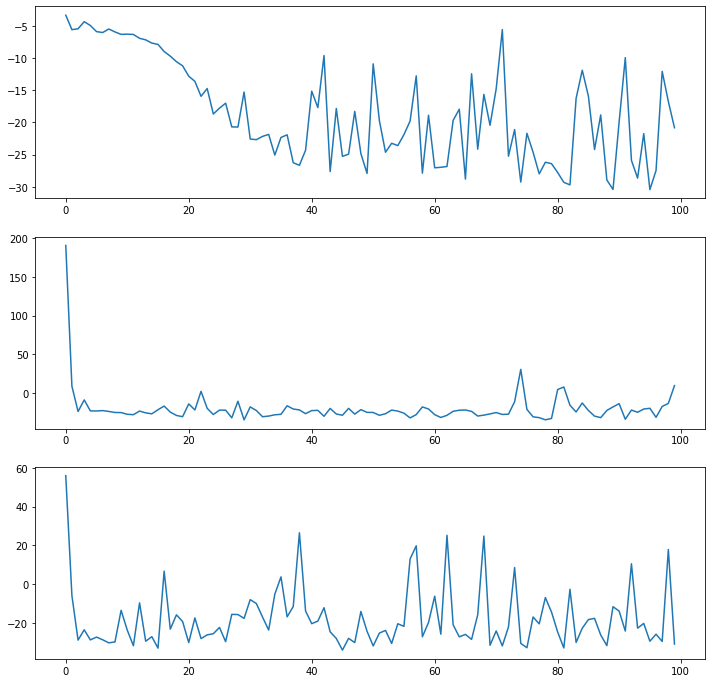

In [13]:
plt.rcParams["figure.figsize"] = (12, 12)
fig, axs = plt.subplots(3)
for i in range(3):
    axs[i].plot(loop_mlp_val_loss[i])
plt.savefig('./mlp_loss.jpg', dpi=800)

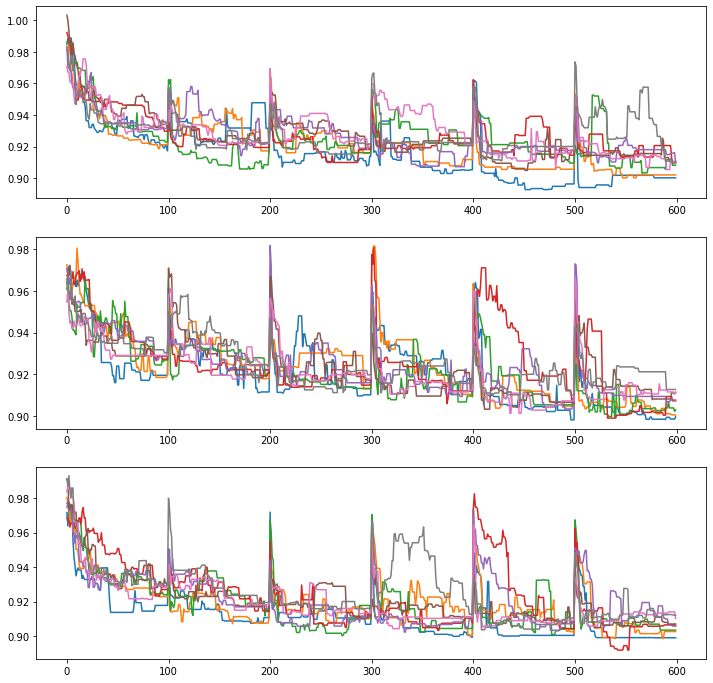

In [14]:
plt.rcParams["figure.figsize"] = (12, 12)
fig, axs = plt.subplots(3)
for i in range(3):
    for j in range(8):
        axs[i].plot(loop_seq_loss[i][j])
plt.savefig('./seqence_loss.jpg', dpi=800)

In [11]:
print(loop_seq[-1])

['GIGAVLKVLKAGLPALIVTLKRKIVQ', 'PPGATLKKHTTGSVALISWIWARIQQ', 'GIGAVLKVLTTGLKTLISAAKRKRAA', 'HAPPVLKVLTTGLAPPLVWIKRKRTH', 'GIGAVLUIHKLSSVAAWRPPKRKRQQ', 'PTWIIFLKAQWEQHSNLTNMRTFPEV', 'TISHFVCNHDICAWIKDMQAMQIKMC', 'CESWLWKRLFDGHADRWRSMPDYPIW', 'YLVENPLMFPLVAAFIHQWTRQISWH', 'QTEERLEAQISIYYIGAWSHYKVTDE', 'PDDGIFQCRCHDSMMMINKHDPSPIH', 'PDDGNFECHCHDGMMMEKRHDPSPPP', 'ENCDGSCICDGPPGKMMGRRFQPWPP', 'TCVNGDCICDCPPGYMMMRRPFPFPP', 'DVCDCECICDSPMGKMMMRRPFPFPP', 'WIPVCECKGSFEYHDEKEEKPMYPPV', 'WNPVCYCKGEFMYHDDKEESPMKPPL', 'PDVNCCIKCRHHDSTAKFDMPEDPPP', 'WKCECKGDSMSNHIEYHPDPPDPFPP', 'EDPDAPFQCRCHDGMMMIKDPPPDGL', 'WRCHCKGDSMYMHVEGHHDSPGPMPP', 'FDVDDICECDAKGAFVYHKDPPGYPP', 'WRCECHDGSFMINIEIHSDPPGPSPP', 'YGEPAPFKCRCHDMMFMMIEEPPDGT', 'PDDCDDPVCKCGCSMMMRIDRPFPPV', 'FEPECHCNCGYGKFEMKIEWPDIDPT', 'PDDTGDITCRCCGGMMMYKKPPDGPP', 'PDGTFHCACCEGFMVEHKDDPDMPPP', 'PDDTGDITCRCHDGTMMIKKDPGKPP', 'PDGNITCSCHEMMMGMNKDYKDPEPP', 'PDDSPDFTCRCDDSMMMARKPPDDPP', 'HVECKCDGKMMMHFRHKDKKDDPPLT', 'HIECKCKGKMFMAHRDSDKKDPMPWP', 'HYECRCKG

In [12]:
hamming(target_seq, 'PDGNITCSCHEMMMGMNKDYKDPEPP')

0.9230769230769231